In [1]:
# Importer les bibliothèques nécessaires
import torch # type: ignore
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

import time
import re, collections

import matplotlib.pyplot as plt

import tqdm
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilisé : {device}")

Device utilisé : cuda


---
---
# Token 

In [3]:
class Tokenizer():
    """ This class is used to tokenize the input text and create a vocabulary of tokens. """
    def __init__(self, text, num_merges):
        self.text = text
        self.num_merges = num_merges

    def initialize_vocabulary(self,text):
        """ Initialize the vocabulary from the input text. """
        vocab = collections.defaultdict(int)
        words = text.strip().split()
        for word in words:
            vocab[' '.join(list(word)) + ' '] += 1
        return vocab
    
    def get_tokens_and_frequencies(self,vocab):
        """ Get the tokens and how often they occur in the vocabulary. """
        tokens = collections.defaultdict(int)
        for word, freq in vocab.items():
            word_tokens = word.split()
            for token in word_tokens:
                tokens[token] += freq
        return tokens
    
    def get_pairs_and_counts(self,vocab):
        """ Get the pairs of tokens and how often they occur in the vocabulary. """
        pairs = collections.defaultdict(int)
        for word, freq in vocab.items():
            symbols = word.split()
            for i in range(len(symbols)-1):
                pairs[symbols[i],symbols[i+1]] += freq
        return pairs
    
    def merge_pair_in_vocabulary(self,pair, vocab_in):
        """ Merge the most frequent pair of tokens in the vocabulary. """
        vocab_out = {}
        bigram = re.escape(' '.join(pair))
        p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
        for word in vocab_in:
            word_out = p.sub(''.join(pair), word)
            vocab_out[word_out] = vocab_in[word]
        return vocab_out
    
    def tokenize(self):
        """ Tokenize the input text. """
        if os.path.exists('./data/tokens_{}merges.pt'.format(self.num_merges)):
            print("Loading tokenized data from file")
            tokens = torch.load('./data/tokens_{}merges.pt'.format(self.num_merges),weights_only=False)
            vocab = torch.load('./data/vocab_{}merges.pt'.format(self.num_merges),weights_only=False)
            return tokens, vocab
        
        # Initialize the vocabulary from the input text
        vocab = self.initialize_vocabulary(self.text)

        # Merge the most frequent pair of tokens num_merges times
        with tqdm.tqdm(range(self.num_merges), position=0, leave=True) as pbar:
            for i in pbar:
                tokens = self.get_tokens_and_frequencies(vocab)
                pairs = self.get_pairs_and_counts(vocab)
                if not pairs:
                    break
                most_frequent_pair = max(pairs, key=pairs.get)
                vocab = self.merge_pair_in_vocabulary(most_frequent_pair, vocab)
                pbar.set_description(f'Num merges: {i + 1}')

        # Find the tokens and how often they occur in the vocabulary one last time
        tokens = self.get_tokens_and_frequencies(vocab)

        tokens[' '] = self.text.count(' ')
        tokens['\n'] = self.text.count('\n')

        torch.save(tokens, './data/tokens_{}merges.pt'.format(self.num_merges))
        torch.save(vocab, './data/vocab_{}merges.pt'.format(self.num_merges))

        return tokens, vocab


    def tokenize_text(self, tokens):
        """ Tokenize the input text using the tokens. """
        # Load tokenized data if it exists
        if os.path.exists('./data/tokenized_{}merges.pt'.format(self.num_merges)):
            print("Loading tokenized data from file")
            tokenized_text = torch.load('./data/tokenized_{}merges.pt'.format(self.num_merges),weights_only=False)
            return tokenized_text

        token_list = list(tokens.keys())
        tokenized_text = []  # List to store the tokenized text
        i = 0  # Index to keep track of the current position in the text

        print("Nombre de tokens trouvés :", len(token_list))

        with tqdm.tqdm(total=len(self.text), position=0, leave=True) as pbar:
            pbar.set_description("Tokenizing text")
            while i < len(self.text):
                match = None
                # loop through the tokens to find the longest match
                for token in sorted(token_list, key=len, reverse=True):
                    if self.text[i:i+len(token)] == token: 
                        match = token
                        break
                    
                if match:  
                    tokenized_text.append(match)
                    i += len(match)  # Move the index to the end of the token
                    pbar.update(len(match))
                else:
                    print("Token non trouvé pour le texte restant :", self.text[i:])
                    break 

        # Save the tokenized text
        torch.save(tokenized_text, './data/tokenized_{}merges.pt'.format(self.num_merges))
        return tokenized_text 

In [4]:
data = open('./data/Shakespeare.txt', 'r').read()

In [5]:
tokenizer = Tokenizer(data, 1000)
tokens, vocab = tokenizer.tokenize()
tokenized_text = tokenizer.tokenize_text(tokens)

Loading tokenized data from file
Loading tokenized data from file


In [6]:
print(len(tokens))

1014


In [7]:
print(tokenized_text[:100])

['First', ' ', 'Citizen:', '\n', 'Be', 'fore', ' ', 'we', ' ', 'pro', 'ce', 'ed', ' ', 'any', ' ', 'f', 'ur', 'ther', ',', ' ', 'hear', ' ', 'me', ' ', 'speak', '.', '\n', '\n', 'All', ':', '\n', 'S', 'pe', 'ak', ',', ' ', 'speak', '.', '\n', '\n', 'First', ' ', 'Citizen:', '\n', 'You', ' ', 'are', ' ', 'all', ' ', 'res', 'ol', 'ved', ' ', 'ra', 'ther', ' ', 'to', ' ', 'die', ' ', 'than', ' ', 'to', ' ', 'fa', 'mis', 'h', '?', '\n', '\n', 'All', ':', '\n', 'R', 'es', 'ol', 'ved', '.', ' ', 'res', 'ol', 'ved', '.', '\n', '\n', 'First', ' ', 'Citizen:', '\n', 'First', ',', ' ', 'you', ' ', 'know', ' ', 'C', 'a', 'i']


---
---
# CharDataset

In [8]:
class CharDataset(Dataset):
    """ This class is used to create a PyTorch dataset from the tokenized text. """
    def __init__(self, tokenized_text, tokens, block_size = 32):

        chars = list(tokens.keys())

        self.stoi = {ch: i for i, ch in enumerate(chars)}
        self.itos = {i: ch for i, ch in enumerate(chars)}

        self.dataset = torch.tensor([self.stoi[ch] for ch in tokenized_text], dtype=torch.long)
        self.set_data_mode()

        
        self.vocab_size = len(chars)
        self.block_size = block_size


    def __len__(self):
        """ Return the number of blocks in the dataset, used by the DataLoader. """



        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        """ Return the input and target sequence. """
        chunk = self.data[idx:idx + self.block_size + 1]
        input_chunk = chunk[:-1]
        target = chunk[1:]
        return input_chunk, target

    def get_vocab_size(self):
        """ Return the size of the vocabulary. """
        return self.vocab_size

    def get_stoi(self):
        return self.stoi

    def get_itos(self):
        return self.itos
    
    def set_data_mode(self, train_mode = True):
        train_len = int(10/11 * len(self.dataset))

        if train_mode:
            self.data = self.dataset[:train_len]
        else:
            self.data = self.dataset[train_len:]

        


In [9]:
dataset = CharDataset(tokenized_text, tokens)

In [10]:
len(dataset.data)

520780

In [11]:
dataset.set_data_mode(train_mode = False)
len(dataset.data)

52078

---
---
# Positional Encoding


$$(sin(\theta), cos(\theta)) $$ 
where 
$$\theta = \frac{t}{r^k},r = N^{2/d} $$

In [12]:
class PositionalEncoding(torch.nn.Module):
    """ This class is used to add positional encoding to the input embeddings. """
    def __init__(self, embedding_dim, max_len=10000):
        super(PositionalEncoding, self).__init__()

        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.pow(max_len ** (2/embedding_dim),-torch.arange(0, embedding_dim, 2))

        pe = torch.zeros(max_len, embedding_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0)) # add the batch dimension
    def forward(self, x):
        return self.pe[:, :x.size(1), :]

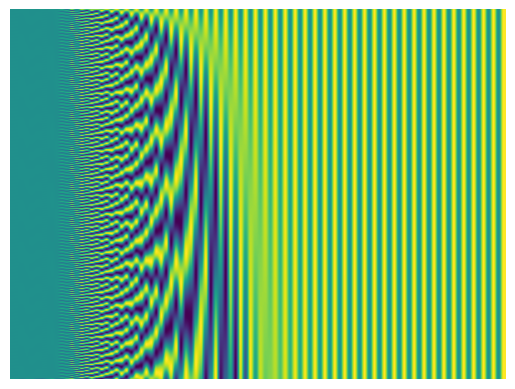

In [13]:
P = PositionalEncoding(100, max_len=10000)

plt.axis('off')
plt.imshow(P.pe.squeeze(0), aspect='auto')
plt.show()


---
---
# Attention

In [14]:
class CausalSelfAttention(nn.Module):
    def __init__(self, n_embd, n_head,n_red, dropout):
        super().__init__()
        self.test = n_red
        self.n_head = n_head
        self.key = nn.Linear(n_embd, n_embd // self.test)
        self.query = nn.Linear(n_embd, n_embd // self.test)
        self.value = nn.Linear(n_embd, n_embd)
        #self.proj = nn.Linear(n_embd, n_embd) # Je ne suis pas sûr de cette ligne

        self.attn_drop = nn.Dropout(dropout)  # Will be used to help model not focusng on a specific token during training
        self.resid_drop = nn.Dropout(dropout)

        self.register_buffer("mask", torch.tril(torch.ones(1024, 1024)).view(1, 1, 1024, 1024))

    def forward(self, x):
        B, T, C = x.size()

        q, k, v = self.query(x), self.key(x), self.value(x)

        # 
        q = q.view(B, T, self.n_head, C // (self.test*self.n_head)).transpose(1, 2)
        k = k.view(B, T, self.n_head, C // (self.test*self.n_head)).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        
        att = (q @ k.transpose(-2, -1)) * (1.0 / (k.size(-1) ** 0.5))
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))
        att = nn.functional.softmax(att, dim=-1)
        att = self.attn_drop(att) 
        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_drop(y)
        return y

---
---
# Transformer block

In [15]:
class TransformerBlock(nn.Module):
    """ This class is used to define a transformer block wich is self attention followed by a feed forward neural network. """
    def __init__(self, n_embd, n_head, n_red, dropout, factor=4):
        super().__init__()
        self.attention = CausalSelfAttention(n_embd, n_head, n_red, dropout)
        self.mlp = nn.Sequential(
            nn.Linear(n_embd, n_embd * factor),
            nn.ReLU(),
            nn.Linear(n_embd * factor, n_embd),  
            nn.Dropout(dropout)
        )
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.attention(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

---
---
# GPT

In [16]:
class GPT(nn.Module):
    """ This class is used to define the GPT model. """
    def __init__(self, vocab_size, block_size, n_embd, n_layer, n_head,n_red, dropout=0.2):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, n_embd) # Embedding layer
        self.position_embedding = PositionalEncoding(n_embd)
        self.layers = nn.ModuleList([ # List of transformer blocks
            TransformerBlock(n_embd, n_head,n_red, dropout) for _ in range(n_layer)
        ])
        self.layer_norm = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size) # Output layer to predict the next token

    def forward(self, idx):
        B, T = idx.size()
        tok_emb = self.token_embedding(idx)
        pos_emb = self.position_embedding(idx)
        x = tok_emb + pos_emb
        for layer in self.layers:
            x = layer(x)
        x = self.layer_norm(x)
        logits = self.lm_head(x)
        return logits

---
---
# Validation Loss

In [17]:
def current_loss(model, dataset, batch_size, device,numpasses,Train_mode = True):
    model.to(device)
    model.eval()
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    total_loss = 0
    count = 0

    dataset.set_data_mode(Train_mode)

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            logits = model(inputs)
            logits = logits.view(-1, logits.size(-1))
            targets = targets.view(-1)
            loss = F.cross_entropy(logits, targets)
            total_loss += loss.item()
            
            count += 1
            if count >= numpasses:
                break

    
    dataset.set_data_mode()
    return total_loss / numpasses

---
---
# Train function

In [36]:
def train_wrt_iters(model, dataset, batch_size, max_iters, lr, device,letter):

    model.to(device)

    iters = 0
    train_losses = []
    test_losses = []

    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True)

    with tqdm.tqdm(total=max_iters, position=0, leave=True) as pbar:
        for inputs, targets in dataloader:

            inputs, targets = inputs.to(device), targets.to(device)

            logits = model(inputs)

            logits = logits.view(-1, logits.size(-1))
            targets = targets.view(-1)

            optimizer.zero_grad()
            loss = F.cross_entropy(logits, targets)
            loss.backward()

            optimizer.step()

            if iters % 100 == 0:
                train_losses.append(current_loss(model, dataset,batch_size, device,10))
                test_losses.append(current_loss(model, dataset,batch_size, device,10,Train_mode = False))

            if iters % 1000 == 0:
                torch.save(model.state_dict(), './saved_models/{}model_{}.pt'.format(letter,iters))

            iters += 1
            if iters > max_iters:
                break

            
            pbar.update()
    return train_losses, test_losses



In [19]:
### PARAMETERS SAVING FUNCTION

import json


def save_params(file_path, params: dict, force=False):
    if not force and os.path.exists(file_path):
        raise FileExistsError("File already exists")
        
    file = open(file_path, 'w', encoding='utf-8')
    json.dump(params, file)
    file.close()

def load_params(file_path):
    file = open(file_path, 'r', encoding='utf-8')
    data = json.load(file)
    file.close()

    return data

---
---
# Acuracy function

In [20]:
def Accuracy(model , dataset,train_data = False, second_best = False):
    model.to(device)
    model.eval()
    dataset.set_data_mode(train_mode = train_data)
    
    correct = 0
    total = 0
    t0 = time.time()

    dataloader = DataLoader(dataset, batch_size=100, shuffle=True, pin_memory=True)

    with torch.no_grad():

        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            logits = model(inputs)
            logits = logits.view(-1, logits.size(-1))
            targets = targets.view(-1)
            
            _, predicted = torch.max(logits, 1)
            correct += (predicted == targets).sum().item()

            if second_best :
                logits[:,predicted] = -float('inf')
                _, predicted2 = torch.max(logits, 1)
                correct += (predicted2 == targets).sum().item()

            total += targets.size(0)
            if time.time() - t0 > 4:
                break

    return round(correct / total, 2)

---
---
# Generate function

In [21]:
# Text generation function
def generate_text(model, start_text, length, stoi, itos, block_size, device):
    model.eval()
    context = torch.tensor([stoi[c] for c in start_text], dtype=torch.long, device=device).unsqueeze(0)
    generated = context.tolist()[0]
    with torch.no_grad():
        for _ in range(length):
            logits = model(context)
            logits = logits[:, -1, :]
            probs = nn.functional.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1).item()
            generated.append(next_token)
            context = torch.tensor(generated[-block_size:], dtype=torch.long, device=device).unsqueeze(0)
    return ''.join(itos[i] for i in generated)

---
---
# Training our model

In [41]:
# Configurations
block_size = 256
batch_size = 64
n_red = 1
n_embd = 384  # Attention : n_reduction * n_head doit diviser n_embd
n_layer = 6
n_head = 6   # Nombre de têtes d'attention (N'affecte pas la vitesse)
n_steps = 2000
lr = 3e-4

# Initialisation du modèle
model = GPT(vocab_size=len(tokens), block_size=block_size, n_embd=n_embd, n_layer=n_layer, n_head=n_head,n_red=n_red)

dataset = CharDataset(tokenized_text, tokens, block_size=block_size)

nb_params = sum([param.view(-1).size()[0] for param in model.parameters()])

print(f"Nombre de paramètres du modèle : {nb_params}")

Nombre de paramètres du modèle : 10540278


In [43]:
letter = 'a'

state_params_saver = {
    'block_size': block_size,
    'batch_size': batch_size,
    'n_red': n_red,
    'n_emb': n_embd,
    'n_layer': n_layer,
    'n_head': n_head,
    'vocab_size': len(vocab)
}

# saving parameters
file_path = f"./saved_models/{letter}_models_params.json"

save_params(file_path, state_params_saver, force=True)


In [44]:
train_losses, test_losses = train_wrt_iters(model, dataset, batch_size, n_steps, lr, device,letter)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [13:41<00:00,  2.43it/s]


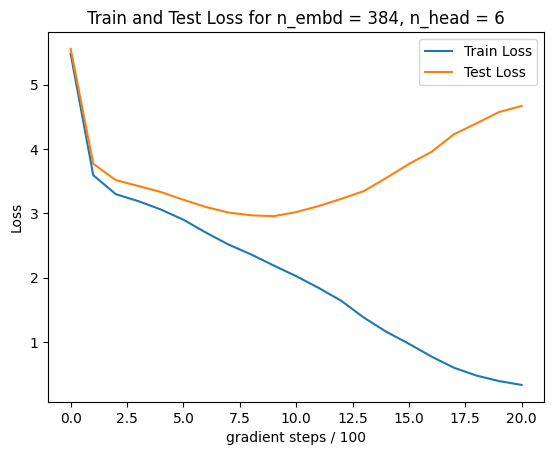

In [62]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('gradient steps / 100')
plt.ylabel('Loss')

plt.title('Train and Test Loss for n_embd = 384, n_head = 6')

plt.legend()
plt.show()

In [56]:
model.load_state_dict(torch.load('./saved_models/amodel_1000.pt'))

C:\Users\cat\AppData\Local\Temp\ipykernel_1380\805393660.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./saved_models/amodel_1000.pt'

<All keys matched successfully>

In [60]:
seed = "My king, my heart"
print(generate_text(model,seed,500,dataset.stoi,dataset.itos,block_size = block_size,device = device))

My king, my heart traitor:
I have seen fear'd by my course, and I
In payond urking, and at the seatly,
Good down.

MENENIUS:
No, but Each youth, gone! Caius Marcius quarre? be long
repent mes lack worthires, well enough fast banish s
With men s are me up of to be reap
To place under such traitors.

SICINIUS:
Which rempe's one;
And we have learr, at his right unacate,
Of utes plaining the coat,--know.

MENENIUS:
You clama noble accept!

First Senator:
We will snow he given to him.

CORIOLANUS:
Who k'st this cowes and he service at
ires be told me in a petition--

SICINIUS:
That, yet the voice of towns'the people's, said of your
father.

MENENIUS:
Think you, you you, as you speak, as you shall Lucition
The to speak of him the reaside our.

BRUTUS:
This reature you.
We am you then have into lease. When Let's great tune stand:
you must Why, not the depenitented,
Returns a precious above to his pomis.

MENENIUS:
I do not bring your tongues: how
It shall shall all thumblics,--
That there are

---
---
# Load a Model

---
---
# Evaluating the model

In [58]:
100*Accuracy(model, dataset)

42.0

In [59]:
100*Accuracy(model, dataset,train_data = True)

55.00000000000001